# Model: <MODEL NAME>

**Objective**  
Membangun dan mengevaluasi model `Random Forest` untuk prediksi risiko gagal bayar (default). dan membandingkan performanya dengan Logistic Regression baseline.

**Baseline Reference**  
Model ini dibandingkan dengan:
- Logistic Regression (baseline)
- Model lain (jika ada)

**Why Random Forest?**
- Mampu menangkap **non-linear relationship**
- Lebih robust terhadap outlier
- Dapat menangani interaksi antar fitur secara otomatis

**Evaluation Focus**
- ROC-AUC
- KS Statistic
- Recall (Default)
- Approval Rate

**Evaluation Focus**
- ROC-AUC
- KS Statistic
- Recall (Default)
- Approval Rate (Business Perspective)


## Import Library

In [1]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report
)

from sklearn.ensemble import RandomForestClassifier

## Load Dataset (Feature Engineered)

In [2]:
DATA_PATH = "../../data/processed/df_model.csv"

df = pd.read_csv(DATA_PATH)

df.shape

(307511, 148)

## Define Target & Features

In [3]:
TARGET = "TARGET"

X = df.drop(columns=[TARGET])
y = df[TARGET]

X.shape, y.value_counts(normalize=True)

((307511, 147),
 TARGET
 0    0.919271
 1    0.080729
 Name: proportion, dtype: float64)

## Train-Test Split (Consistent)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

## Model Training

In [5]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    min_samples_leaf=50,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

rf_model


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",8
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",50
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

In [6]:
rf_model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",8
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",50
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

## Prediction & Probability 

In [7]:
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

## ROC Curve & AUC

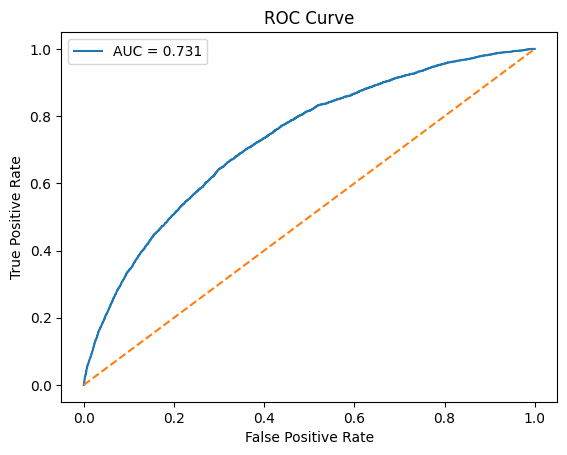

0.730997156258513

In [8]:
auc = roc_auc_score(y_test, y_proba)

fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

auc

## KS Statistic 

In [9]:
def ks_statistic(y_true, y_proba):
    df_ks = pd.DataFrame({
        "y": y_true,
        "proba": y_proba
    }).sort_values("proba")

    cdf_good = np.cumsum(df_ks["y"] == 0) / (df_ks["y"] == 0).sum()
    cdf_bad = np.cumsum(df_ks["y"] == 1) / (df_ks["y"] == 1).sum()

    return np.max(np.abs(cdf_bad - cdf_good))

ks = ks_statistic(y_test.values, y_proba)
ks


np.float64(0.3444316946846112)

## Confusion Matrix (Defatul Treshold = 0.5)

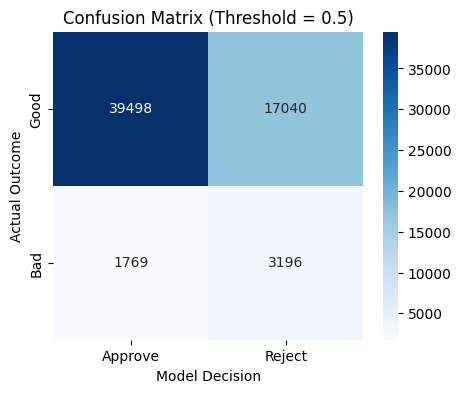

array([[39498, 17040],
       [ 1769,  3196]])

In [10]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Approve", "Reject"],
    yticklabels=["Good", "Bad"]
)
plt.xlabel("Model Decision")
plt.ylabel("Actual Outcome")
plt.title("Confusion Matrix (Threshold = 0.5)")
plt.show()

cm

## Classfication Report

In [11]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.70      0.81     56538
           1       0.16      0.64      0.25      4965

    accuracy                           0.69     61503
   macro avg       0.56      0.67      0.53     61503
weighted avg       0.89      0.69      0.76     61503



## Business Perspective

In [12]:
approval_rate = (y_pred == 0).mean()
approval_rate

np.float64(0.6709753995740045)

## Feature Importance / Coefficient

In [13]:
feature_importance = pd.Series(
    rf_model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

feature_importance.head(15)


EXT_SOURCE_3                                         0.219948
EXT_SOURCE_2                                         0.173837
EXT_SOURCE_1                                         0.081371
EMPLOYED_YEARS                                       0.062148
AGE_YEARS                                            0.041103
AMT_GOODS_PRICE                                      0.027677
NAME_EDUCATION_TYPE_Higher education                 0.022987
DAYS_LAST_PHONE_CHANGE                               0.022719
LOG_CREDIT                                           0.015777
DAYS_ID_PUBLISH                                      0.015276
NAME_EDUCATION_TYPE_Secondary / secondary special    0.014663
REGION_RATING_CLIENT_W_CITY                          0.012299
NAME_INCOME_TYPE_Working                             0.011483
LOG_ANNUITY                                          0.011391
REGION_RATING_CLIENT                                 0.010183
dtype: float64

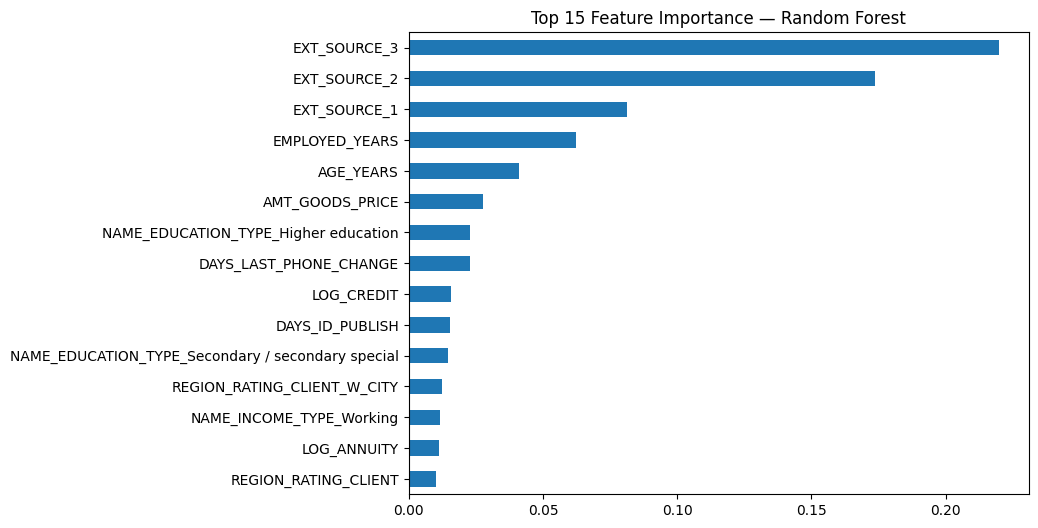

In [14]:
plt.figure(figsize=(8, 6))
feature_importance.head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importance — Random Forest")
plt.show()

## Summary & Comparison

## Model Summary

| Metric | Value |
|------|------|
| AUC | 0.730997156258513 |
| KS | 0.3444316946846112 |
| Recall (Default) | 64% |
| Approval Rate | |

### Key Observations
- Random Forest menangkap hubungan non-linear
- Recall default meningkat / menurun dibanding Logistic Regression
- Approval rate berubah signifikan

### Recommendation
- Gunakan RF sebagai **challenger model**
- Logistic Regression tetap baseline karena interpretability
